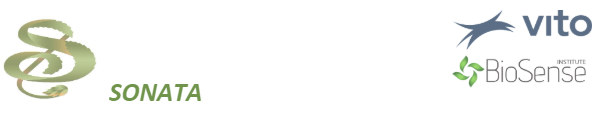
<br>
## training on VITO's hierarchical habitat mapping workflow for openEO processing platform
<br>
Copyrights, license and restrictions <br>
All code snippets, visualizations or/and workflow ideas are property of VITO. Work has been developed since 2021 and is still in development by VITO.
Showed public and private repositories are owned by VITO. <br>
(Re)sharing is only allowed with proper citation of the owners. Publications (peer-review, reports, ...) based partly and/or fully on VITO's hierarchical habitat mapping framework or on one of the provided GitHub repositories must be prior aligned with Dr. Marcel Buchhorn.
Code usage is allowed with proper citation, see author list in repository.
<br>
base repository: https://github.com/ESA-WEED-project/eo_processing

### Model Generation: Train 5-fold Catboost model


In [2]:
from pathlib import Path
import pickle
import numpy as np
import pandas as pd
import os
import geopandas as gpd
#from tensorflow.keras.utils import to_categorical
import sklearn.model_selection
from catboost import CatBoostClassifier
# Remove outliers
from pyod.models.ecod import ECOD
import seaborn as sns
import itertools
import json
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder
import pickle
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
from SONATA.supporting_scripts.lut_encoder import HabitatEncoder

#### First have to set up many functions

##### Filter features with lots of NaN's
##### Filter habitats that have less than 9 training points, we cannot trust classifying on these ones.
###### The classes with less than 9 points are stored in the removed_habitats_v1.txt file. In case all classes within a level-class combination have less than 9 points, the script will not store these classes in the removed_habitats_v1.txt file, since none of these classes will be able to be modeled.
##### Outlier detection for feature values within a habitat class.

In [3]:
def filter_nan_feats(df):
    filtered_inputfts = []
    # Now check for features which are often NaN are always the same as we won't use those
    for ft in df.columns:
        if np.sum(np.isfinite(df[ft].values)) > 0.8 * df.shape[0] and len(np.unique(df[ft].values)) > 1:
            filtered_inputfts.append(ft)
    return filtered_inputfts


def filter_habitats(original_df):
    min_samples = 9
    habitats = original_df.index.get_level_values('habitat').to_list()
    habitat_counts = pd.Series(habitats).value_counts()
    ignore_labels = habitat_counts[habitat_counts < min_samples].index
    before = len(df)
    filtered_df = original_df.loc[~original_df.index.get_level_values(
        'habitat').isin(ignore_labels)]
    after = len(filtered_df)
    removed = np.unique(ignore_labels)
    print(
        f'Removed habitats {removed} with less than {min_samples} samples. Removed {before - after} samples.')

    return filtered_df, removed


def drop_outliers(original_df):
    outlierinputs = original_df.columns
    outlierfraction = 0.05
    # split the dataset and run outlier removal on only one part
    nremoved = 0
    dfs = []
    print(f'Obs before OD: {original_df.shape[0]}')
    unique_labels = original_df.index.get_level_values('habitat').unique()
    for label in unique_labels:
        dftoclean = original_df.loc[df.index.get_level_values(
            'habitat') == label]
        if dftoclean.shape[0] < 30:
            # Not enough samples for this label: skip
            # OD routine
            dfs.append(dftoclean)
            continue
        # get the variables used for outlier removal
        outlier_x = dftoclean[outlierinputs].values
        # Get rid of any existing NaN values
        outlier_x[np.isnan(outlier_x)] = 0
        # fit the model
        clf = ECOD(contamination=outlierfraction)
        clf.fit(outlier_x)
        # get the prediction labels
        y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)  # NOQA
        nremoved += y_train_pred.sum()
        retain_idx = np.where(y_train_pred == 0)
        dfclean = dftoclean.iloc[retain_idx]
        dfs.append(dfclean)
    df_no_outliers = pd.concat(dfs)
    print(f'Removed {nremoved} outliers')
    return df_no_outliers

##### Function for encoder
##### Encoder gives a unique raster value to each unique habitat class (in EUNIS2021PLUS typology)

In [4]:
def init_encoder(feature_df, eunis_lut_path):
    habitats = feature_df.index.get_level_values('habitat').to_list()
    encoder = HabitatEncoder(
        eunis_lut_path)  # converting habitat labels into a format suitable for machine learning models
    encoder.fit(habitats)
    num_output_classes = len(np.unique(habitats))
    return encoder, habitats, num_output_classes

##### Functions for some evaluation metrics: habitat distribution, (normalized) confusion matrix and feature importance

In [5]:
def habitat_distribution(feature_df, outpath):
    f, ax = plt.subplots(1, 1)
    counts = feature_df.index.get_level_values('habitat').value_counts()
    plt.bar(np.arange(len(counts)), counts.values)
    ax.set_xticks(np.arange(len(counts)))
    ax.set_xticklabels(counts.index, rotation=90)
    ax.grid()
    plt.ylabel('Nr. of samples')
    plt.savefig(outpath / 'habitat_distribution.jpg',
                dpi=300, bbox_inches="tight")


def confusion_matrix(encoder, model, X_test, y_test):
    predictions = model.predict(X_test)
    cm = sklearn.metrics.confusion_matrix(encoder.inverse_transform(y_test),
                                          encoder.inverse_transform(
                                              predictions),
                                          labels=encoder.classes_)
    # normalized confusion matrix
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    return cm, cmn


def plot_confusion_matrix(cm, cmn, encoder, filtered_inputfts, outpath):
    # Normalized cm plot
    fig, ax = plt.subplots(figsize=(12, 10))
    sns.heatmap(cmn, annot=True, fmt='.1f',
                xticklabels=encoder.classes_.astype(str),
                yticklabels=encoder.classes_.astype(str))
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.yticks(rotation=0)
    plt.rcParams.update({'font.size': 8})
    plt.title(f'nFeat: {len(filtered_inputfts)}', fontsize=15)
    outfile = outpath / 'confusion_matrix_norm.png'
    plt.tight_layout()
    plt.savefig(outfile, facecolor='white', transparent=False)

    # Not normalized cm plot
    fig, ax = plt.subplots(figsize=(12, 10))
    sns.heatmap(cm, annot=True,
                xticklabels=encoder.classes_.astype(str),
                yticklabels=encoder.classes_.astype(str))
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.yticks(rotation=0)
    plt.rcParams.update({'font.size': 8})
    plt.title(f'nFeat: {len(filtered_inputfts)}', fontsize=15)
    outfile = outpath / 'confusion_matrix.png'
    plt.tight_layout()
    plt.savefig(outfile, facecolor='white', transparent=False)


def feature_importance_plot(model, predictors, outdir):
    sns.set_style('white')
    ft_imp = model.get_feature_importance()
    sorting = np.argsort(np.array(ft_imp))[::-1]
    f, ax = plt.subplots(1, 1, figsize=(18, 6))
    ax.bar(np.array(predictors)[
               sorting], np.array(ft_imp)[sorting])
    ax.set_xticklabels(np.array(
        predictors)[sorting], rotation=90)
    plt.tight_layout()
    plt.ylabel('Feature importance')
    plt.savefig(str(outdir / 'feature_importance.png'),
                dpi=300, bbox_inches="tight")


##### Train the 5-fold Catboost and choose the best model based on checking the confusion matrices

In [7]:
def train_fold(X_train, y_train, train_index, val_index, num_output_classes):
    # generate fold training and validation sets
    X_val, y_val = X_train.loc[val_index, :], y_train[val_index]
    X_train_, y_train_ = X_train.loc[train_index, :], y_train[train_index]

    # Assign class weights to compensate for the unbalance
    class_weights = compute_class_weight(
        'balanced', classes=np.unique(y_train_), y=y_train_)

    if num_output_classes > 2:
        # multi-class training
        model = CatBoostClassifier(
            class_weights=class_weights,
            iterations=6000, depth=8,
            learning_rate=0.05,
            early_stopping_rounds=20,
            # classes_count=num_output_classes,
            verbose=100,
            random_seed=10)
    else:
        # binary training
        model = CatBoostClassifier(
            class_weights=class_weights,
            iterations=6000, depth=8,
            learning_rate=0.05,
            early_stopping_rounds=20,
            verbose=100,
            random_seed=10)
    model.fit(X_train_, y_train_, eval_set=(X_val,
                                            y_val))
    return model


def evaluate_fold(model, X_test, y_test):
    # test model on unseed test set
    predictions = model.predict(X_test)
    # store model and performance
    try:
        f1_score = sklearn.metrics.f1_score(
            y_test, predictions, average='weighted')
    except:
        predictions = list(itertools.chain(*predictions))
        f1_score = sklearn.metrics.f1_score(
            y_test, predictions, average='weighted')
    return f1_score, predictions


def run_5fold_training_catboost(feature_df, filtered_inputfts, eunis_lut_path):
    # create and save encoder for model classes
    encoder, habitats, num_output_classes = init_encoder(
        feature_df, eunis_lut_path)

    # convert classes through encoder and filter input according to selected bands
    X = feature_df[filtered_inputfts].reset_index(drop=True)
    y = np.array(habitats)
    y = encoder.transform(y)

    # var for saving models and scores
    models = []
    f1_scores = []

    # initialize splitters
    sss_traintest = StratifiedShuffleSplit(
        n_splits=1, test_size=.15, random_state=0)
    sss_trainval = StratifiedShuffleSplit(
        n_splits=5, test_size=.15, random_state=0)

    # STRATIFIED 5-fold TRAINING CATBOOST
    y_test_list = []
    test_index_list = []
    for train_index, test_index in sss_traintest.split(X, y):
        # extract test dataset that will be used to choose the best model after training alle the folds
        X_test, y_test = X.loc[test_index, :].reset_index(
            drop=True), y[
            test_index]  # change to y[np.array(test_index).astype(int)]? --> TypeError: only integer scalar arrays can be converted to a scalar index
        X_train, y_train = X.loc[train_index, :].reset_index(
            drop=True), y[train_index]

        # separate training into 5 folds of validation and training datasets
        for i, (train_index, val_index) in enumerate(sss_trainval.split(X_train, y_train)):
            print(f"Training CatBoost model on Fold {i}")
            model = train_fold(X_train, y_train, train_index,
                               val_index, num_output_classes)
            f1_scores.append(evaluate_fold(model, X_test, y_test)[0])
            models.append(model)

    best_model = select_best_model(f1_scores, models)

    # produce confusion matrices
    cm, cmn = confusion_matrix(encoder, best_model, X_test, y_test)

    return best_model, encoder, cm, cmn

def select_best_model(f1_scores, models):
    best_model = models[np.argmax(f1_scores)]
    print(f'F1 scores: {f1_scores}')
    return best_model

##### Save the models
###### models for all the levels can be stored into the same json file!

In [8]:
def model_json(outdir, level, n_predictors, version, class_):
    if os.path.exists(str(outdir / f'models_{model_version}.json')):
        with open(str(outdir / f'models_{model_version}.json'), 'r') as file:
            model_dict = json.load(file)
    else:
        model_dict = {}
    new_model = f"Level{level}_{class_}_{n_predictors}predictors_{version}"  # class_ is taken as L1, not as class-0???
    model_dict[new_model] = str(model_outdir)  # Convert model_outdir to string
    with open(str(outdir / f'models_{model_version}.json'), 'w') as outfile:
        json.dump(model_dict, outfile)

#### Run the model generation

##### Specify input
##### model_version: which version are you running
##### area: which biogeographical zone are you running
##### hier_level: are you creating models for L1, L2 or L3
##### json_outdir: specifiy output folder where json file (that stores path to models) can be saved

Processing class-0
114 input features
Removed habitats [] with less than 9 samples. Removed 0 samples.
Obs before OD: 81935
Removed 4101 outliers
Training CatBoost model on Fold 0
0:	learn: 2.2209355	test: 2.2213978	best: 2.2213978 (0)	total: 185ms	remaining: 18m 30s


KeyboardInterrupt: 

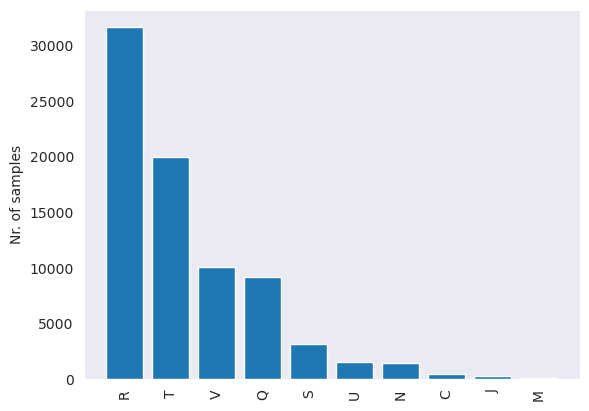

In [9]:
if __name__ == "__main__":
    model_version = 'v1'
    area = 'Pannonian'
    hier_level = "1"
    json_outdir = Path(f"/data/habitat/EU_Habitat_Models/Base_year_2024_v1/Pannonian/models/v1") # path to where you want to store the model json file
    eunis_lut_path = "/data/habitat/EU_Habitat_Models/Base_year_2024_v1/Pannonian/LUT_topology_EUNIS2021plus_v1.xlsx" # path to the encoder LUT (has to be xlsx file no csv!)
    level_paths = list(
        Path(f"/data/habitat/EU_Habitat_Models/Base_year_2024_v1/Pannonian/models/v1/L{hier_level}/").glob('class*'))  # path to where the class folders within level 2 and level 3 are stored
    if not level_paths:
        level_paths = [Path(f"/data/habitat/EU_Habitat_Models/Base_year_2024_v1/Pannonian/models/v1/L{hier_level}")] # path to where data for level 1 is stored

    with open(json_outdir / f'removed_habitats_{model_version}.txt', 'w') as report:
        for level_path in level_paths:
            level_path = level_path / "data"
            if 'class' in str(level_path):
                cl = os.path.basename(str(level_path.parent))
            else:
                cl = 'class-0'
            # load selected features
            try:
                selected_features = pd.read_csv(
                    list(level_path.glob("*selectedFeatures.txt"))[0]).columns.to_list()
                selected_features[0] = selected_features[0].replace(
                    'selected_features: ', '')
            except:
                print(
                    'no file with selected features found. Using all features for training')
                selected_features = None  # first: selected_feature (without s!)
            print(f'Processing {cl}')
            # remove lc feature if present
            if 'lc' in selected_features:
                del selected_features[selected_features.index('lc')]

            # load feature dataframe and filter
            df = pd.read_csv(list(level_path.glob("*all_features.csv"))[0],
                             index_col=['entry', 'habitat'], skipinitialspace=True)

            # Track original indices before any filtering for test_index
            original_indices = df.index

            if selected_features:
                df = df[selected_features]

            filtered_inputfts = filter_nan_feats(df)
            df = df[filtered_inputfts]
            print(f'{len((filtered_inputfts))} input features')

            import json

            with open(level_path / 'predictors.json', 'w') as outfile:
                outfile.write(json.dumps(filtered_inputfts))

            # filter habitats if few samples
            df, removed = filter_habitats(df)
            report.write(str(removed) + '\n')

            # drop outliers
            df = drop_outliers(df)

            # save plot habitat distribution
            habitat_distribution(df, level_path)

            # Set up outpath
            model_outdir = level_path.parent / \
                           f'models_test/{len(filtered_inputfts)}predictors/{model_version}/'
            model_outdir.mkdir(parents=True, exist_ok=True)
            model_outdir.chmod(0o755)

            if len(df.index.get_level_values('habitat').unique().to_list()) > 1:
                best_model, encoder, cm, cmn = run_5fold_training_catboost(
                        df, filtered_inputfts, eunis_lut_path)

                # Save encoder, best model and predictors
                pickle.dump(encoder, open(model_outdir / 'encoder', 'wb'))

                modelname = f'catboost_{model_version}.cbm'
                best_model.save_model(model_outdir / modelname)

                with open(model_outdir / 'predictors.json', 'w') as outfile:
                    outfile.write(json.dumps(filtered_inputfts))

                # keep trace of all produced models so that they can be used in parallel to produce the final maps at
                # the final classification step

                print(cl)

                model_json(json_outdir, hier_level, len(
                    filtered_inputfts), model_version, cl)  # class_ = cl

                # plots of normalized and not normalized confusion matrix of the best model
                plot_confusion_matrix(
                    cm, cmn, encoder, filtered_inputfts, model_outdir)

                # generate feature importance plot
                feature_importance_plot(
                    best_model, filtered_inputfts, model_outdir)
            else:
                print(
                    f"Cannot run Catboost for class {cl}: Only {df.index.get_level_values('habitat').unique().to_list()} habitat left after filtering.")
                continue
        report.close()